In [1]:
import draw
import data_Manager
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from HyperParameters import HP
import train as tu
import generate as g
model_name = "model_weight_cat_20_epochs"

Using TensorFlow backend.


In [2]:
# model for predicting the inital state 
batch_z = tf.keras.Input(shape=(HP.latent_dim,))
initial_state = tf.keras.layers.Dense(units=(2*HP.dec_hidden_size), activation='tanh', name = "decoder_init_stat")(batch_z)
latent_to_hidden_state_model = tf.keras.Model(inputs=batch_z, outputs=initial_state)
latent_to_hidden_state_model.load_weights("model/"+model_name+".h5", by_name = True)
latent_to_hidden_state_model.summary()

W0827 03:36:35.700091 140259093956416 deprecation.py:506] From /home/mario/git/Sketch-rnn/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
decoder_init_stat (Dense)    (None, 1024)              263168    
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
_________________________________________________________________


In [3]:
# create the LSTM for generating
"""
We have 3 input tensor. The input of the LSTM and the hidden states 
"""
decoder_input = tf.keras.Input(shape=(1, 5 + HP.latent_dim))
initial_h_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
initial_c_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
# now the LSTM
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")

# creation of the LSTM
decoder_output, h_new, c_new = decoderLSTM(decoder_input, initial_state = [initial_h_input, initial_c_input])
# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Now we load the weights from the trained model
generator = tf.keras.models.Model([decoder_input, initial_h_input, initial_c_input], outputs =[ distribution_output , h_new, c_new])
generator.summary()
generator.load_weights("model/"+model_name+".h5", by_name = True)
generator.build(tf.TensorShape([1, None])) 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 261)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
LSTM_decoder (LSTM)             [(None, 1, 512), (No 1585152     input_2[0][0]                    
                                                                 input_3[0][0]              

In [4]:
"""
Create the encoder that embed the z
"""
encoder_input = tf.keras.layers.Input(shape = (HP.max_seq_length, HP.input_dimention), name = "encoder_input" )

encoderLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP.enc_hidden_size, return_sequences=False,
    recurrent_dropout=HP.rec_dropout, name = "LSTM_encoder"), merge_mode='concat', name = "BI_LSTM_encoder")(encoder_input)

hidden_state_mean = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "mean_MLP")(encoderLSTM)

hidden_state_variance = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "variance_MLP")(encoderLSTM)
# Now we load the weights from the trained model
encoder = tf.keras.models.Model(encoder_input,[hidden_state_mean, hidden_state_variance])
encoder.summary()
encoder.load_weights("model/"+model_name+".h5", by_name = True)

W0827 03:36:41.703675 140259093956416 deprecation.py:506] From /home/mario/git/Sketch-rnn/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 03:36:41.704904 140259093956416 deprecation.py:506] From /home/mario/git/Sketch-rnn/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 03:36:41.705897 140259093956416 deprecation.py:506] From /home/mario/git/Sketch-rnn/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 200, 5)]     0                                            
__________________________________________________________________________________________________
BI_LSTM_encoder (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
mean_MLP (Dense)                (None, 256)          131328      BI_LSTM_encoder[0][0]            
__________________________________________________________________________________________________
variance_MLP (Dense)            (None, 256)          131328      BI_LSTM_encoder[0][0]            
Total params: 799,232
Trainable params: 799,232
Non-trainable params: 0
____________________

In [11]:
HP.data_location = "data/cat.npz"
datas = data_Manager.Data()

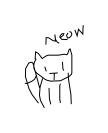

In [15]:
import random
x = datas.train[0]
x_2 = np.expand_dims(x, axis = 0)
mean, variance = encoder.predict(x_2)
latent = np.random.rand(1,HP.latent_dim)*np.exp(variance/2)+mean
draw.draw_strokes(x, svg_filename="results/cat_original.svg")

end of sketch


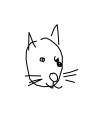

In [17]:
seq =  g.generate_sketch(generator, latent_to_hidden_state_model, latent, temperature=0.2)
draw.draw_strokes(seq, svg_filename="results/cat_from_latent.svg")